# Multiclass classification with Pocket Algorithm

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from typing import Optional
from tqdm import tqdm
import pandas as pd
import numpy as np
import ssl
import sys

np.random.seed(42)

# Load & Transform MNIST dataset

### Download the data

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
mnist = fetch_openml('mnist_784', version=1, parser='auto')

### Data Partitioning
Split the data into training and test sets.
The training set will be used to train the model while the test
set will be used to evaluate the model's performance on unseen data.

* split - I chose to split the data into 80% training and 20% test sets (according to the task description)
* shuffle - I choose to the data before splitting it into training and test sets
* stratify - I chose to stratify the data to ensure that the training and test sets have approximately the same percentage of samples of each target class as the complete set.

In [3]:
# X is the data, y is the label
X, y = mnist['data'], mnist['target']
# Split data into train and test set with shuffle and stratify for equal distribution of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, shuffle=True, stratify=y)
y_train = np.array(y_train, dtype=np.int8)
y_test = np.array(y_test, dtype=np.int8)

### Data Transformation
* Flatten the images from 28x28 to 784x1 (already done while loading the data)
* Add a bias term to the data so that each sample is a 785x1 vector
* Normalization - scale the data to have zero mean and unit variance.
* One-hot encode to the labels.


In [4]:
# *The data is already flatten.

# Add bias column to X_train and X_test
bias = np.ones((X_train.shape[0], 1))
X_train = np.hstack((bias, X_train))
bias = np.ones((X_test.shape[0], 1))
X_test = np.hstack((bias, X_test))

# Normalize the data to make the data less senstive to very high or very low values.
X_train = X_train / 255

# One hot encode the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

### Display the data shapes for sanity check and transparency

In [5]:
print(f'X_train shape: {X_train.shape} (type: {type(X_train[0, 0])})')
print(f'X_test shape: {X_test.shape} (type: {type(X_test[0, 0])})')
print(f'y_train shape: {y_train.shape} (type: {type(y_train[0])})')
print(f'y_test shape: {y_test.shape} (type: {type(y_test[0])})')

X_train shape: (60000, 785) (type: <class 'numpy.float64'>)
X_test shape: (10000, 785) (type: <class 'numpy.float64'>)
y_train shape: (60000, 10) (type: <class 'numpy.ndarray'>)
y_test shape: (10000, 10) (type: <class 'numpy.ndarray'>)


# The Multiclass Pocket (Perceptron) Model
* Binary perceptron classification for each digit.
* Stop condition for the pocket: Abort the training if the zero-one loss is less than 0.025 (bigger than 0.975).
* I chose to calculate the dot product of all the training set with the current weight vector. It's vectorized version which calculated fast.
* I chose to initialize the weights to uniform disterbution between -0.1 to 0.1

In [10]:
class MultiClassPocket(object):
    def __init__(self, epochs):
        self.epochs = epochs
        self.weights = self.get_weights()
        self.labels = self.get_labels()
        self.train_loss = {l: [] for l in self.labels}
        self.test_loss = {l: [] for l in self.labels}

    def PLA(self, X, y, current_w):
        """
            Perceptron Learning Algorithm.
        """
        y_hats = np.sign(current_w @ X_train.T)
        current_w += np.sum((y - y_hats)[:, np.newaxis] * X, axis=0)
        return current_w

    def binary_pocket(self, X_train, y_train_l, X_test, y_test_l, current_w, l):
        """
            Binary classification for each digit.
            Calculate the error during the training for train and test set and save it for plotting.
            Abort the training if the zero-one loss is less than 0.03 (bigger then 0.97).
        """
        old_Ein_w, Ein_w, Eout_w = X_train.shape[0], X_train.shape[0], X_train.shape[0]
        tqdm_epochs = tqdm(range(self.epochs))
        for epoch in tqdm_epochs:
            w_plus_1 = self.PLA(X_train, y_train_l, current_w)
            Ein_w = np.sum(np.sign(w_plus_1 @ X_train.T) != y_train_l) / X_train.shape[0]
            Eout_w = np.sum(np.sign(w_plus_1 @ X_test.T) != y_test_l) / X_test.shape[0]
            if Ein_w < old_Ein_w:
                current_w = w_plus_1
                old_Ein_w = Ein_w
                self.train_loss[l].append(Ein_w)
                self.test_loss[l].append(Eout_w)
                tqdm_epochs.set_description(f"Epoch: {epoch} with: Ein = {round(Ein_w, 5)} | Eout = {round(Eout_w, 5)}")
                if (1 - Ein_w) > 0.975:
                  break
        return current_w

    def fit(self, X_train, y_train, X_test, y_test):
        """
            Fit the model using training data.
            Preform binary classification for each digit.
            * Because it's a binary classification, we set y_train to 1 for current digit, -1 for others.
        """
        for l in self.labels:
            print(f'Digit: {l}')
            y_train_l = np.where(self.one_hot_to_digit(y_train) == l, 1, -1)
            y_test_l = np.where(self.one_hot_to_digit(y_test) == l, 1, -1)
            self.weights[l] = self.binary_pocket(X_train, y_train_l, X_test, y_test_l, self.weights[l], l)

    def predict(self, X):
        """
            Predict the label for each data point in X.
        """
        scores = self.weights @ (X.T)
        return np.argmax(scores, axis=0)

    def get_weights(self):
        """
            Initialize the weights with random values between -0.1 and 0.1.
        """
        weights = np.random.uniform(-0.1, 0.1, (10, 785))
        return np.array(weights)

    def get_labels(self):
        """
            Return the labels for the digits as one hot vector.
        """
        return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    def one_hot_to_digit(self, one_hot_array):
        digit_list = np.argmax(one_hot_array, axis=1)
        return np.array(digit_list)

    def my_confusion_matrix(self, y, y_hats):
        """
            Calculate the:
                confusion matrix.
                accuracy for the whole test set.
                accuracy, sensitivity and selectivity for each digit.
        """
        y = self.one_hot_to_digit(y)
        confusion_mtx = confusion_matrix(y, y_hats)
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=self.labels)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax)
        plt.show()

        # Find true prdiction (where y == y_hats)
        TP = np.sum( y == y_hats)
        accuracy = TP / y.shape[0]
        print('Test set accuracy: ', accuracy)

        for l in self.labels:
            print(f'{l} confusion matrix & metrics:')
            y_l = np.where(y == l, 1, 0)
            y_hats_l = np.where(y_hats == l, 1, 0)

            confusion_mtx = confusion_matrix(y_l, y_hats_l)
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['not ' + str(l), str(l)])
            fig, ax = plt.subplots(figsize=(4, 4))
            disp.plot(ax=ax)
            plt.show()

            # Find true positive (where y_l == 1 and y_hats_l == 1) and y_l == 1
            TP = np.sum(np.logical_and(y_l, y_hats_l))
            # Find true negative (where y_l == 0 and y_hats_l == 0) and y_l == 0
            TN = np.sum(np.logical_and(np.logical_not(y_l), np.logical_not(y_hats_l)))
            # Find false positive (where y_l == 0 and y_hats_l == 1) and y_l == 0
            FP = np.sum(np.logical_and(np.logical_not(y_l), y_hats_l))
            # Find false negative (where y_l == 1 and y_hats_l == 0) and y_l == 1
            FN = np.sum(np.logical_and(y_l, np.logical_not(y_hats_l)))

            accuracy = (TP + TN) / (TP + TN + FP + FN)
            sensitivity_TPR = TP / (TP + FN)
            selectivity_TNR = TN / (TN + FP)

            print('accuracy: ', accuracy)
            print('sensitivity_TPR: ', sensitivity_TPR)
            print('selectivity_TNR: ', selectivity_TNR)

    def plot_loss_for_each_class(self):
        """
            Plot the in sample and out of sample error for each digit.
        """
        fig, axes = plt.subplots(nrows=len(self.labels), ncols=1, figsize=(10, 20))
        for i, l in enumerate(self.labels):
            axes[i].plot(self.train_loss[l], label=f'digit {l}')
            axes[i].plot(self.test_loss[l], label=f'digit {l} test')
            axes[i].set_xlabel('Time t (number of update)')
            axes[i].set_ylabel('Loss')
            axes[i].set_title(f'Loss for digit {l}')
            axes[i].legend()
        plt.tight_layout()
        plt.show()

    def plot_loss_for_all_classes(self):
      """
        Plot in sample error of all classes in one graph.
      """
      fig, ax = plt.subplots(figsize=(10, 6))

      for i, l in enumerate(self.labels):
          color = plt.cm.get_cmap('tab10')(i / len(self.labels))
          ax.plot(self.train_loss[l], label=f'{l}', color=color, linestyle='-')
      ax.set_xlabel('Time t (number of update)')
      ax.set_ylabel('Loss')
      ax.set_title('Loss for each digit')
      ax.legend()
      plt.tight_layout()
      plt.show()

# Training
* Initialize the model parameters
* Implement the Pocket Algorithm

I choose to run the algorithm for 500 epochs per class.

In [11]:
classifier = MultiClassPocket(epochs=500)
classifier.fit(X_train, y_train, X_test, y_test)

Digit: 0


Epoch: 8 with: Ein = 0.02423 | Eout = 0.0241:   2%|▏         | 8/500 [00:04<04:08,  1.98it/s]


Digit: 1


Epoch: 2 with: Ein = 0.02182 | Eout = 0.0185:   0%|          | 2/500 [00:01<04:57,  1.67it/s]


Digit: 2


Epoch: 67 with: Ein = 0.02485 | Eout = 0.0248:  13%|█▎        | 67/500 [00:26<02:50,  2.54it/s]


Digit: 3


Epoch: 497 with: Ein = 0.02487 | Eout = 0.0261:  99%|█████████▉| 497/500 [02:14<00:00,  3.69it/s]


Digit: 4


Epoch: 44 with: Ein = 0.02493 | Eout = 0.0265:   9%|▉         | 44/500 [00:11<02:02,  3.72it/s]


Digit: 5


Epoch: 434 with: Ein = 0.02578 | Eout = 0.0246: 100%|██████████| 500/500 [02:29<00:00,  3.35it/s]


Digit: 6


Epoch: 15 with: Ein = 0.02485 | Eout = 0.0226:   3%|▎         | 15/500 [00:04<02:39,  3.04it/s]


Digit: 7


Epoch: 23 with: Ein = 0.02487 | Eout = 0.0233:   5%|▍         | 23/500 [00:08<02:48,  2.84it/s]


Digit: 8


Epoch: 150 with: Ein = 0.0549 | Eout = 0.0563: 100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


Digit: 9


Epoch: 499 with: Ein = 0.03877 | Eout = 0.0428: 100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


# Evaluation
* Evaluate the model's performance on the test set

In [12]:
y_hats = classifier.predict(X_test)

* Display the confusion matrix
* Display the accuracy on the test set
* Display the accuracy, sensitivity, specificity for each class

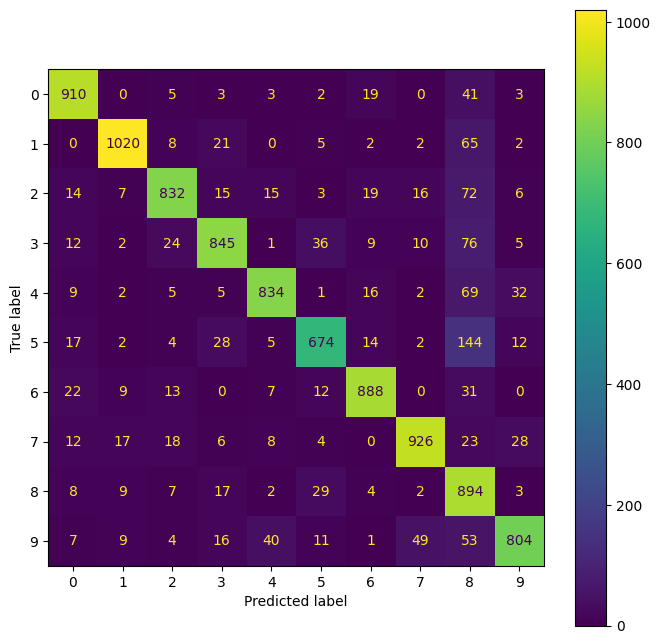

Test set accuracy:  0.8627
0 confusion matrix & metrics:


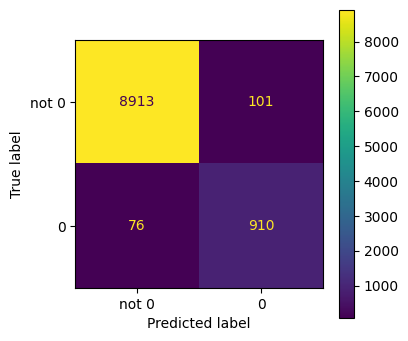

accuracy:  0.9823
sensitivity_TPR:  0.922920892494929
selectivity_TNR:  0.9887952074550699
1 confusion matrix & metrics:


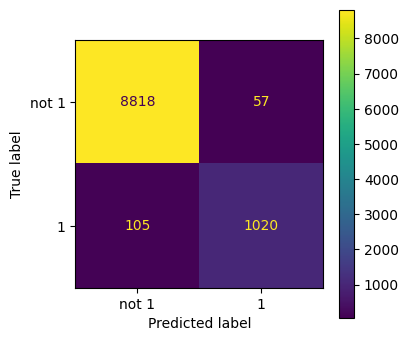

accuracy:  0.9838
sensitivity_TPR:  0.9066666666666666
selectivity_TNR:  0.9935774647887324
2 confusion matrix & metrics:


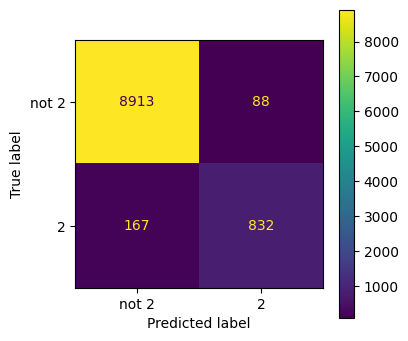

accuracy:  0.9745
sensitivity_TPR:  0.8328328328328328
selectivity_TNR:  0.9902233085212754
3 confusion matrix & metrics:


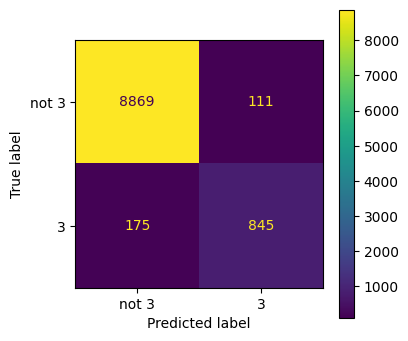

accuracy:  0.9714
sensitivity_TPR:  0.8284313725490197
selectivity_TNR:  0.9876391982182628
4 confusion matrix & metrics:


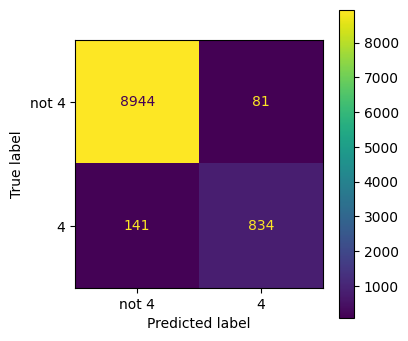

accuracy:  0.9778
sensitivity_TPR:  0.8553846153846154
selectivity_TNR:  0.9910249307479224
5 confusion matrix & metrics:


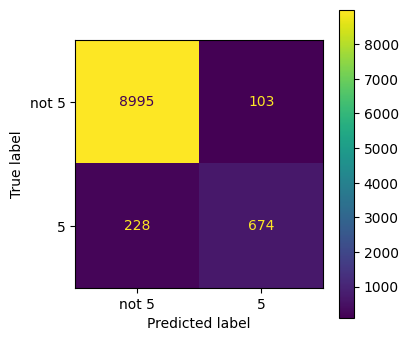

accuracy:  0.9669
sensitivity_TPR:  0.7472283813747228
selectivity_TNR:  0.9886788305122005
6 confusion matrix & metrics:


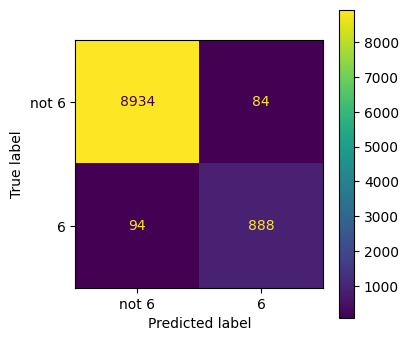

accuracy:  0.9822
sensitivity_TPR:  0.9042769857433809
selectivity_TNR:  0.9906852960745176
7 confusion matrix & metrics:


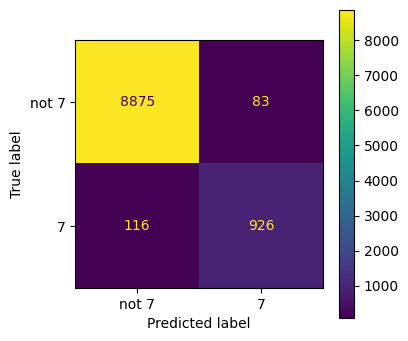

accuracy:  0.9801
sensitivity_TPR:  0.8886756238003839
selectivity_TNR:  0.9907345389595892
8 confusion matrix & metrics:


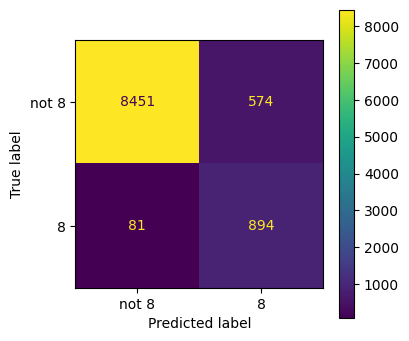

accuracy:  0.9345
sensitivity_TPR:  0.916923076923077
selectivity_TNR:  0.936398891966759
9 confusion matrix & metrics:


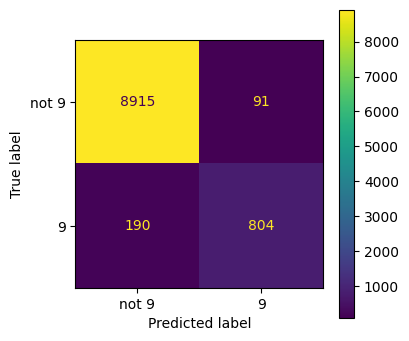

accuracy:  0.9719
sensitivity_TPR:  0.8088531187122736
selectivity_TNR:  0.9898956251387964


In [13]:
classifier.my_confusion_matrix(y_test, y_hats)

# Conclusions
* We get 0.8627 accuracy on the whole test set
* I've tried to run the model with 200 epochs and I got 0.81 accuracy.
* The total time to train the model is 9 minutes, which is slightly too much. I have also tried to run it with less epochs and got between 3 to 7 minutes. I prefered to choose 9 minutes with high accuracy instead of low accuracy and fast runtime.
* In the training, we can see the model needed different number of epochs to converge for each class.
* The model converged faster for the digits 0, 1, 2, 4, 6, 7 and slower for the digits 3, 5, 8, 9.
* In addition, we can notice for a low TPR value for digit 5 (0.74) while the other digits have higher TPR values between 0.8-1.0
* We can see that the diagonal of the confusion matrix has the highest values, which means that the model is good at classifying the digits to their true class.

## Display The errors while training
* Display in and out of sample errors on the same graph to see if the model is overfitting or not
* I chose to display the graph with x axis of time t (number of update) according to the theory.

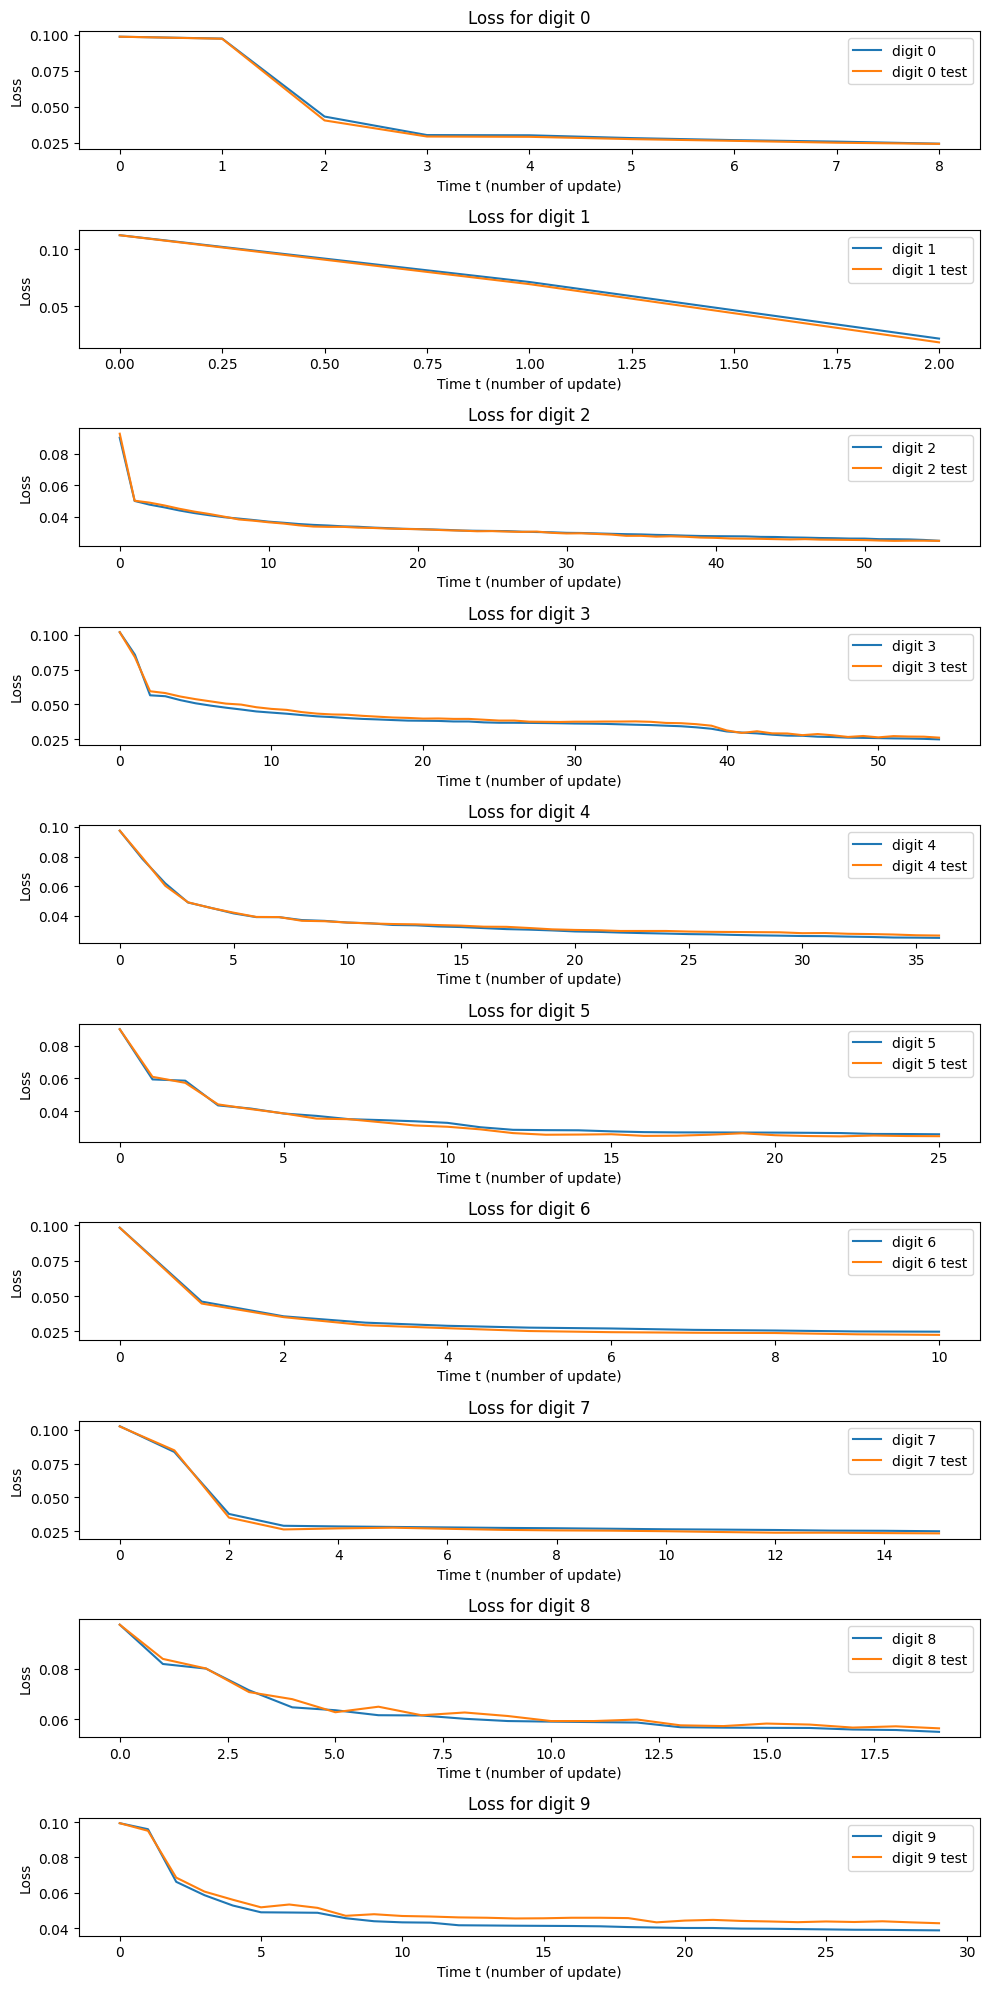

In [14]:
classifier.plot_loss_for_each_class()

# More conclusions
* We can see that the training error is sligtly lower than the test error,which make sense. But the difference is not very big, so we can say that the model is not overfitting.
* Also, the error is decreasing with the number of updates, as expected.
* The last point is occurring becuase I am using a stopping condition in the binary_pocket function.

# Display the in sample error for all classes in one graph

<ipython-input-10-d425591eccba>:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('tab10')(i / len(self.labels))


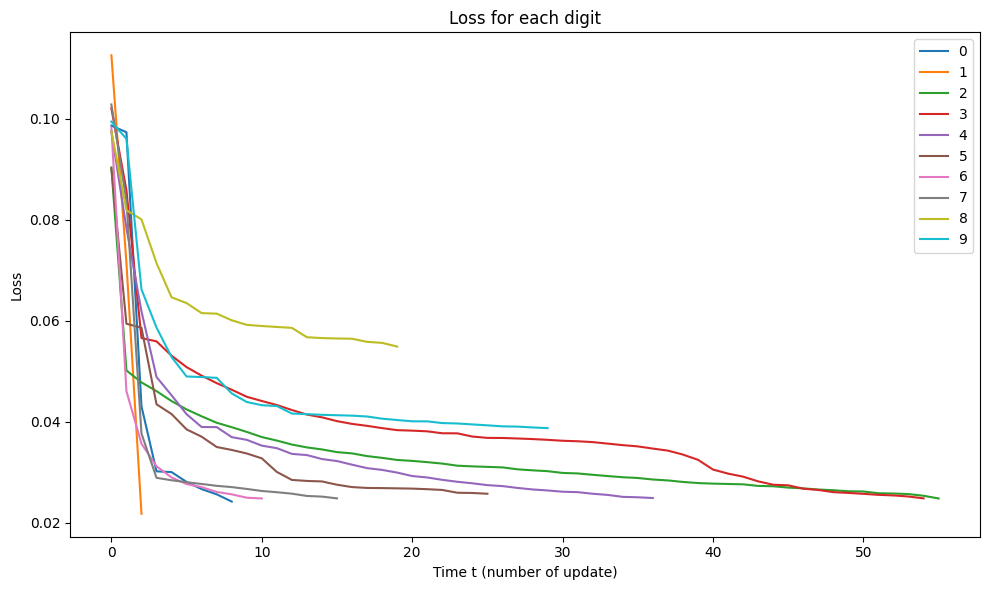

In [15]:
classifier.plot_loss_for_all_classes()

* We can see that there are digits that need more updates than the others. For example 2 and 3.
* Some digits converge faster than others. For example 0 and 1.

# Summary
* The accuracy of the model with 500 iterations for each class is 0.8627
* It took approximately 6 minutes for the model to converge for all the digits together.
* More optimization techniques can be used to gain higher metrics values.
* trying to change the parameters of the model can be helpful to get higher accuracy.